#Exploring Patterns of Population Structure and Environmental Associations to Aridity Across the Range of Loblolly Pine

##Introduction

In this set of analyses, we will be making use of data from the Eckert et al. 2010 paper to explore patterns of phenotypic and environmental associations among populations of loblolly pine.


###Abstract

Natural populations of forest trees exhibit striking phenotypic adaptations to diverse environmental
gradients, thereby making them appealing subjects for the study of genes underlying ecologically relevant phenotypes. Here, we use a genome-wide data set of single nucleotide polymorphisms genotyped across 3059 functional genes to study patterns of population structure and identify loci associated with aridity across the natural range of loblolly pine (Pinus taeda L.). Overall patterns of population structure, as inferred using principal components and Bayesian cluster analyses, were consistent with three genetic clusters likely resulting from expansions out of Pleistocene refugia located in Mexico and Florida. A novel application of association analysis, which removes the confounding effects of shared ancestry on correlations between genetic and environmental variation, identified five loci correlated with aridity. These loci were primarily involved with abiotic stress response to temperature and drought. A unique set of 24 loci was identified as FST outliers on the basis of the genetic clusters identified previously and after accounting for expansions out of Pleistocene refugia. These loci were involved with a diversity of physiological processes. Identification of nonoverlapping sets of loci highlights the fundamental differences implicit in the use of either method and suggests a pluralistic, yet complementary, approach to the identification of genes underlying ecologically relevant phenotypes.


##Overview of tasks

In general, what you will be doing is working your way from loading and saving data related to this study, to corrections for population structure, to looking for associations between genotypes and phenotypes, genotypes and the environment (`Bayenv2`), and genotypes+phenotypes+environment (`SQUAT`)

## This notebook

With this notebook, you will explore both environmental and phenotypic associations with your SNP loci using the method we call SQUAT or Berg/Coop.  The citation for this method is in the slides, but you can get the paper [here](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1004412).

In this notebook you will work with:

1. population specific allele frequencies
1. SNPassoc in R to obtain genotypic mean estimates for your 3 genotypic classes
1. Calclulate $\alpha$ for each of your SNPs
1. Use estimates of frequency and alpha to compute $Qx$
1. Investigate effects of populations using $z$-scores

As with the previous notebook, execute the cell with the imports and continue

In [1]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
import statsmodels as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

%load_ext autoreload
%autoreload 2

sns.set_context("talk")

In [2]:
%%R
library(qvalue)

In [3]:
def convert_to_snpassoc(col):
    if "-" in col.name:
        freqs = af[col.name]
        trans = {11: "%s/%s" % (freqs["A"], freqs["A"]),
                12: "%s/%s" % (freqs["A"], freqs["a"]),
                22: "%s/%s" % (freqs["a"], freqs["a"]),
                "NA":"NA"}
        return col.apply(lambda x: trans[x])
    return col

def get_phenotype(row):
    return np.max(pheno[(pheno.Longitude==row.long) & (pheno.Latitude==row.lat)])

def center_and_standardize_value(val, u, var):
    if val == -1:
        return 0.0
    return (val-u)/np.sqrt(var)

def center_and_standardize(snp):
    maf = af.ix["q",snp.name]
    u = np.mean([x for x in snp if x != -1])
    var = np.sqrt(maf*(1-maf))
    return snp.apply(center_and_standardize_value, args=(u, var))

def add_county_id(row):
    key = "%s_%s" % (row.county,row.state)
    if key in county_id:
        return county_id[key]
    return np.nan

In [4]:
r = ro.r

In [5]:
pwd

u'/gdc_home5/groups/congenomics/day5/cfried'

####Let's pull in some data

You'll need:

* your trait of interest
* the dictionary mapping population names to ids
* the PCA covariance matrix esimtated earlier
* your phenotypes
* the global allele frequencies

In [6]:
hdf = HDFStoreHelper("data.hd5")

In [7]:
trait_name = dill.load(open("trait_name.dill"))
county_id = dill.load(open("county_id.dill"))
pca_cov = hdf.get('pca_cov')
loc_hierf = hdf.get("loc_hierf")
pheno = hdf.get('pheno')
af = hdf.get("af")

In [8]:
trait = loc_hierf.apply(get_phenotype, axis=1)

In [9]:
trait_loc_hierf = trait.join(loc_hierf, how="inner")

In [10]:
trait_complete = trait_loc_hierf.drop(trait_loc_hierf[np.isnan(trait_loc_hierf[trait_name])].index)
trait_complete['countyid'] = trait_complete.apply(add_county_id, axis=1)

In [11]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [12]:
%%R
ls()

character(0)


In [16]:
print r["trait_data"]

    Longitude Latitude fructose        county state      lat      long
3   -76.87746 37.66986 5.800560  KING & QUEEN    VA 37.66986 -76.87746
4   -76.87746 37.66986 5.800560  KING & QUEEN    VA 37.66986 -76.87746
5   -76.97319 37.51160 5.827951      NEW KENT    VA 37.51160 -76.97319
7   -77.42219 36.39032 5.737403   NORTHAMPTON    NC 36.39032 -77.42219
8   -78.70453 34.33010 5.824822      COLUMBUS    NC 34.33010 -78.70453
12  -79.30539 33.36318 5.958635    GEORGETOWN    SC 33.36318 -79.30539
13  -77.05205 35.55349 5.945595      BEAUFORT    NC 35.55349 -77.05205
15  -77.06917 35.10917 5.872764        CRAVEN    NC 35.10917 -77.06917
18  -77.05205 35.55349 5.945595      BEAUFORT    NC 35.55349 -77.05205
20  -77.06917 35.10917 5.872764        CRAVEN    NC 35.10917 -77.06917
21  -77.06917 35.10917 5.872764        CRAVEN    NC 35.10917 -77.06917
24  -77.06917 35.10917 5.872764        CRAVEN    NC 35.10917 -77.06917
25  -77.05205 35.55349 5.945595      BEAUFORT    NC 35.55349 -77.05205
26  -7

In [14]:
ro.globalenv['trait_data'] = trait_complete

In [17]:
trait_complete.head()

,Longitude,Latitude,fructose,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
3,-76.87746,37.66986,5.800560,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,22,11,11,12,11,...,11,11,11,11,11,11,12,11,NA,12,11,12,12,11,11
4,-76.87746,37.66986,5.800560,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,12,11,NA,11,12,...,11,11,12,11,11,11,12,11,11,12,11,12,11,12,11
5,-76.97319,37.51160,5.827951,NEW KENT,VA,37.51160,-76.97319,NEW KENT_VA,NaN,12,11,12,22,11,12,...,11,11,12,11,12,11,12,11,NA,12,11,12,11,12,12
7,-77.42219,36.39032,5.737403,NORTHAMPTON,NC,36.39032,-77.42219,NORTHAMPTON_NC,NaN,12,12,12,11,12,12,...,11,11,11,12,12,11,12,11,12,12,11,11,12,11,22
8,-78.70453,34.33010,5.824822,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,...,11,NA,12,11,11,11,11,11,NA,11,11,12,11,12,22


####Let's keep only those rows that have the trait we care about

In [18]:
trait_complete = trait_complete[trait_complete.countyid > 0]

In [19]:
trait_complete.shape

(330, 3091)

####Let's convert to SNPassoc format and join the data with the PCA covariance matrix

This gets all of the data together in one frame so that we can use the PCs to correct for population structure in our genotypic mean estimates

In [20]:
trait_snpassoc = trait_complete.apply(convert_to_snpassoc)

In [21]:
trait_snpassoc_pca = trait_snpassoc.join(pca_cov, how="inner")

In [22]:
trait_snpassoc_pca.head()

,Longitude,Latitude,fructose,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,...,UMN-CL97Contig,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
8,-78.70453,34.33010,5.824822,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,A/A,C/C,G/G,G/G,G/G,...,A/A,-3.639308,1.929420,1.193841,-3.447265,0.971588,1.904022,-2.019537,4.332102,-2.889919,1.682956,-6.441526,4.149832,-0.223308,-0.780265
12,-79.30539,33.36318,5.958635,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,C/A,NA,NA,G/G,G/A,...,NA,2.329722,1.624366,0.335046,-0.417052,-1.013743,-0.138149,1.068138,0.402887,-0.010373,0.559439,2.445590,0.335334,-0.047097,-1.344021
13,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,A/A,NA,C/G,G/A,G/G,A/A,...,G/G,-2.708652,3.668354,4.708462,0.815316,5.354841,5.688271,6.544227,1.869980,-0.408042,2.274323,0.627999,-6.249547,-8.086907,8.983447
15,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,A/G,C/A,C/G,G/A,G/G,G/A,...,G/G,-3.152409,2.664518,2.302811,-0.078610,0.237071,-3.257392,-2.636748,3.809404,-0.443443,7.257342,-0.466697,1.824831,-0.198020,-1.268526
18,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,A/A,C/C,G/G,G/G,G/A,G/A,...,G/G,-3.806482,2.723616,-5.248239,-2.665990,4.428649,-2.327034,-2.104905,5.450938,-3.403810,-0.727319,4.328464,-1.099518,0.683061,0.534313


####Let's make the data more manageable.

Have a look at it

In [23]:
trait_snpassoc_pca = trait_snpassoc_pca.drop(['county_state',
                         'Longitude',
                         'Latitude',
                         'county',
                         'state',
                         'lat',
                         'long',
                         'countyid'], axis=1)

In [24]:
trait_snpassoc_pca.head()

,fructose,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,...,UMN-CL97Contig,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
8,5.824822,NA,A/A,C/C,G/G,G/G,G/G,A/A,G/G,A/A,A/G,NA,A/A,A/G,A/C,...,A/A,-3.639308,1.929420,1.193841,-3.447265,0.971588,1.904022,-2.019537,4.332102,-2.889919,1.682956,-6.441526,4.149832,-0.223308,-0.780265
12,5.958635,NA,C/A,NA,NA,G/G,G/A,A/A,G/G,A/C,A/G,A/C,A/A,A/A,A/A,...,NA,2.329722,1.624366,0.335046,-0.417052,-1.013743,-0.138149,1.068138,0.402887,-0.010373,0.559439,2.445590,0.335334,-0.047097,-1.344021
13,5.945595,A/A,NA,C/G,G/A,G/G,A/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,...,G/G,-2.708652,3.668354,4.708462,0.815316,5.354841,5.688271,6.544227,1.869980,-0.408042,2.274323,0.627999,-6.249547,-8.086907,8.983447
15,5.872764,A/G,C/A,C/G,G/A,G/G,G/A,A/A,G/G,A/A,G/G,A/C,A/T,A/A,C/C,...,G/G,-3.152409,2.664518,2.302811,-0.078610,0.237071,-3.257392,-2.636748,3.809404,-0.443443,7.257342,-0.466697,1.824831,-0.198020,-1.268526
18,5.945595,A/A,C/C,G/G,G/G,G/A,G/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,A/A,...,G/G,-3.806482,2.723616,-5.248239,-2.665990,4.428649,-2.327034,-2.104905,5.450938,-3.403810,-0.727319,4.328464,-1.099518,0.683061,0.534313


####This part gets a little crazy, mostly due to how we chose to run SNPassoc in the past.  Making an R script seems to be the most straight-forward way to do it.

In [25]:
trait_snpassoc_pca.to_csv("%s_snpassoc.txt" % trait_name,
                             header=True,
                             index=True,
                             sep="\t")

In [26]:
"%s_snpassoc.txt" % trait_name

'fructose_snpassoc.txt'

In [27]:
def write_snpassoc_file(df, input_file, num_pca_axes):
    pheno = df.columns[0:1]
    out_files = []
    for p in pheno:
        with open("snpassoc_%s_%s.R" % (os.path.basename(input_file), p.lower()), "w") as o:
            print "writing %s" % o.name
            out_files.append(o.name)
            text = '''
library(SNPassoc)

d = read.table('%s', sep="\\t", row.names=1, header=T)

#subtract b/c those are the PCA axes
snp_cols = 2:(ncol(d)-%d)
snp_data = setupSNP(d, colSNPs=snp_cols, sep="/")
pca_cols = (ncol(d)-%d):ncol(d)
pca_data = d[,pca_cols]

wg = WGassociation(%s~1+pca_data$PC1+pca_data$PC2+pca_data$PC3+pca_data$PC4+
pca_data$PC5+pca_data$PC6+pca_data$PC7+pca_data$PC8+pca_data$PC9+pca_data$PC10+
+pca_data$PC11+pca_data$PC12+pca_data$PC13+pca_data$PC14, 
data=snp_data, 
model="co", 
genotypingRate=5)

saveRDS(wg, "wg_%s_co.rds")
stats = WGstats(wg)
saveRDS(stats, "wgstats_%s.rds")
''' % (input_file, 
       num_pca_axes,
       num_pca_axes-1,
       p, 
       p.lower(), 
       p.lower())
        
            o.write(text)
    return out_files

In [28]:
write_snpassoc_file(trait_snpassoc_pca, "%s_snpassoc.txt" % trait_name, 14)

writing snpassoc_fructose_snpassoc.txt_fructose.R


[u'snpassoc_fructose_snpassoc.txt_fructose.R']

##Run in R

```R
source('snpassoc_cfried_melezitose_snpassoc.txt_melezitose.R')
```

If you've used a different file name, just change it so that it's the file that you get back from the function above.  You can do this from the terminal.

####Let's pull that snpassoc data.

The file names may change depending on your trait.  Just get the names of those files and change in them for `wg_trait_co.rds` and `wgstats_trait.rds`

In [29]:
%%R
wg_trait_co.rds = readRDS('wg_melezitose_co.rds')
wgstats_trait.rds = readRDS('wgstats_melezitose.rds')

####This pulls the data from R into python so we can do something useful with it.

In [30]:
wgstats_trait = r['wgstats_trait.rds']
wgstats_trait_labels = r('labels(wg_trait_co.rds)')

In [31]:
wgstats = {trait_name:[wgstats_trait, wgstats_trait_labels.rx2(1)]}
for key, datalist in wgstats.items():
    print "converting %s" % key
    wgstats[key] = [com.convert_robj(x) for x in datalist]

converting fructose


####This set of functions computes $\alpha$

In [32]:
def get_alleles(data):
    a = set()
    for x in data.index:
        for elem in x.split("/"):
            a.add(elem)
    return list(a)  

def get_allele_freqs_wg(data, AA, Aa, aa):
    total = np.sum(data['n'])*2
    A = data.ix[AA, "n"]*2 + data.ix[Aa, "n"]
    a = data.ix[aa, "n"]*2 + data.ix[Aa, "n"]
    return A/total, a/total

def get_genotypes(data, alleles):
    homos = ["%s/%s" % (x,x) for x in alleles]
    Aa = "%s/%s" % (alleles[0], alleles[1])
    if Aa not in data.index:
        Aa = Aa[::-1] #reverse it
    AA, aa = homos
    if data.ix[AA, "n"] < data.ix[aa, "n"]:
        AA, aa = homos[::-1] #reverse it so that major is first
    return AA, Aa, aa

def get_genotypic_values(data, alleles):
    AA, Aa, aa = get_genotypes(data, alleles)
    G_AA = float(data.ix[AA, 'me'])
    G_aa = float(data.ix[aa, 'me'])
    additive = (G_AA-G_aa)/2
    G_Aa = float(data.ix[Aa, 'me'])
    dominance = G_Aa - ((G_AA+G_aa)/2)
    return additive, dominance, AA, Aa, aa
    
def get_alpha(data):
    alleles = get_alleles(data)
    additive, dominance, AA, Aa, aa = get_genotypic_values(data, alleles)
    p, q = get_allele_freqs_wg(data, AA, Aa, aa)
    alpha = additive + (dominance*(q-p))
    return alpha, AA, aa, p, q

####Compute alpha values for your phenotype

The code is from a larger analysis that I've done, and I didn't change it for here.  The `python for p in wgstats:` part is for if you run multiple phenotypes at the same time.  For these examples, though, you just have one.

In [33]:
alpha_vals = {}
for p in wgstats:
    print "running %s" % p
    df = pd.DataFrame(index=["alpha", "p-value", "AA", "aa", "p", "q"])
    alpha_vals[p] = df
    d = wgstats[p][0]
    labels = wgstats[p][1]
    for i, locus in enumerate(d):
        try:
            data = pd.DataFrame(d[locus])
            snp = labels[i]
            genotypes = [g for g in data.index if "/" in g]
            data = data.ix[genotypes,:]
            pvalue = data['p-value'].dropna()[0]
            if len(genotypes) == 3:
                alpha, AA, aa, p, q = get_alpha(data)
                df[snp] = [alpha, pvalue, AA, aa, p, q]
        except Exception as e: 
            pass

running fructose


####The alpha vals `DataFrame` actually contains more than just $\alpha$

I tend to do this a lot, group stats together. 

In [34]:
alpha_vals[trait_name].head(6)

,X0.10037.01.257,X0.10040.02.394,X0.10044.01.392,X0.10048.01.60,X0.10051.02.166,X0.10054.01.402,X0.10079.02.168,X0.10112.01.169,X0.10113.01.119,X0.10116.01.165,X0.10151.01.86,X0.10162.01.255,X0.1022.02.173,X0.10240.01.410,X0.10262.01.558,...,UMN.CL228Contig1.03.181,UMN.CL22Contig1.02.132,UMN.CL239Contig1.03.104,UMN.CL298Contig1.04.378,UMN.CL306Contig1.04.261,UMN.CL307Contig1.04.143,UMN.CL326Contig1.05.421,UMN.CL339Contig1.05.39,UMN.CL34Contig1.03.89,UMN.CL362Contig1.07.133,UMN.CL363Contig1.01.233,UMN.CL379Contig1.12.117,UMN.CL424Contig1.03.94,UMN.CL54Contig1.07.88,UMN.CL97Contig
alpha,-0.02634913,-0.05690412,0.07017136,0.03558499,-0.02413922,0.04328724,-0.02227026,0.007385507,0.01212555,0.0499099,-0.01000692,-0.03223806,-0.03645684,0.03023947,0.003170117,...,0.0602667,-0.05858812,-0.009311692,0.02895194,0.01132639,-0.01049589,0.01288622,-0.03629308,-0.03593668,-0.01017023,-0.03388197,-0.03779547,0.008186138,0.008444086,0.002275688
p-value,0.2532518,0.1788077,0.05405308,0.48018,0.3175836,0.3643437,0.4366601,0.8373771,0.4662918,0.07003658,0.6666358,0.1382056,0.3202204,0.869659,0.8879599,...,0.6572657,0.1048093,0.7491086,0.5701891,0.5970456,0.2841588,0.03399721,0.2289611,0.2330856,0.3408673,0.1710336,0.629122,0.8493699,0.7324662,0.8618279
AA,G/G,T/T,G/G,A/A,A/A,G/G,A/A,A/A,C/C,G/G,T/T,C/C,A/A,G/G,G/G,...,G/G,A/A,A/A,A/A,G/G,C/C,C/C,G/G,G/G,G/G,A/A,A/A,A/A,A/A,G/G
aa,A/A,A/A,A/A,C/C,G/G,A/A,G/G,G/G,G/G,C/C,A/A,G/G,G/G,A/A,A/A,...,A/A,G/G,C/C,C/C,A/A,A/A,A/A,A/A,A/A,A/A,G/G,G/G,G/G,G/G,A/A
p,0.7299383,0.6554878,0.9542683,0.8953846,0.8611111,0.9832827,0.9542587,0.9557927,0.781155,0.859375,0.620743,0.8929664,0.5358255,0.8308824,0.6168831,...,0.9097859,0.8853211,0.9230769,0.7602524,0.9054487,0.7268519,0.893617,0.7092308,0.7261538,0.6833856,0.933642,0.9095092,0.5926518,0.5639344,0.8323077
q,0.2700617,0.3445122,0.04573171,0.1046154,0.1388889,0.01671733,0.04574132,0.04420732,0.218845,0.140625,0.379257,0.1070336,0.4641745,0.1691176,0.3831169,...,0.09021407,0.1146789,0.07692308,0.2397476,0.09455128,0.2731481,0.106383,0.2907692,0.2738462,0.3166144,0.06635802,0.0904908,0.4073482,0.4360656,0.1676923


####Have a look at the p-values.  Does the distribution surprise you?  

Also do the same for the $\alpha$ values.  Ask your self, or a neighbor, the same question.  

* What does this tell you about the effect sizes of the SNPs?  
* Is it what you would expect for polygenic adaptation?

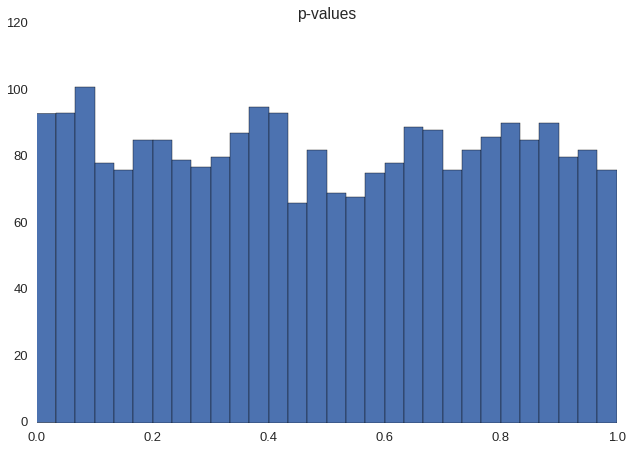

In [35]:
plt.hist(alpha_vals[trait_name].ix['p-value',:], bins=30)
plt.title("p-values")
plt.show()

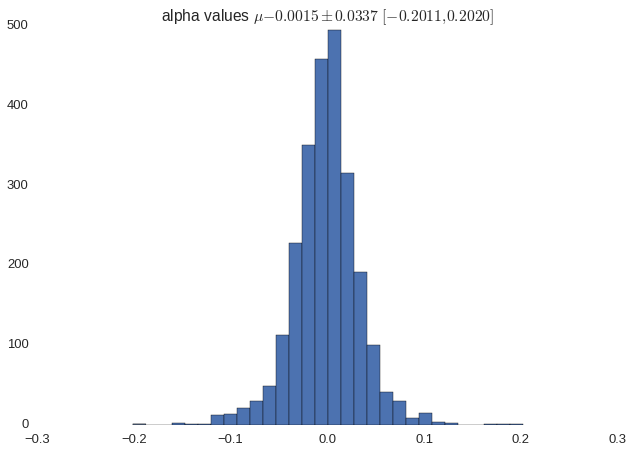

In [36]:
plt.hist(alpha_vals[trait_name].ix['alpha',:], bins=30)
plt.title("alpha values $\mu %.4f \pm %.4f \ [%.4f, %.4f]$" % (np.mean(alpha_vals[trait_name].ix['alpha',:]),
                                                            np.std(alpha_vals[trait_name].ix['alpha',:]),
                                                            np.min(alpha_vals[trait_name].ix['alpha',:]),
                                                             np.max(alpha_vals[trait_name].ix['alpha',:])))
plt.show()

In [37]:
def is_homozygous(gt):
    if len(set([x.strip() for x in gt.split("/")])) == 1:
        return True
    return False

def get_allele_counts(counts):
    a = {}
    het = 0
    for gt in counts.index:
        for allele in [x.strip() for x in gt.split("/")]:
            if not allele in a:
                a[allele] = 0
            a[allele] += counts[gt]
        if not is_homozygous(gt):
            het += counts[gt]
    return sorted(a.items(), key=lambda x: x[1], reverse=True), het

def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def get_allele_freqs(locus):
    locus = locus[locus != '?/?']
    locus = locus[locus != 'NA']
    c = locus.value_counts()
    c = c.sort(inplace=False, ascending=False)
    allele_counts = get_allele_counts(c)
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    A = ""
    a = ""
    P = 0
    Q = 0
    if len(allele_counts[0]) == 2:
        A = allele_counts[0][0][0]
        a = allele_counts[0][1][0]
        P = allele_counts[0][0][1]
        Q = allele_counts[0][1][1]
    else:
        A = allele_counts[0][0][0]
        P = P = allele_counts[0][0][1]
    PQ = allele_counts[-1]
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis,
                    "PQ": PQ,
                    "total_alleles":total_alleles,
                    "num_indiv":num_individuals,
                    "A":A,
                    "a":a})
    return ret

####We need to organize our data by county again, find those which have counties, and then recompute the allele frequencies

In [38]:
trait_snpassoc_pca_county = pd.concat([trait_complete.countyid, trait_snpassoc_pca], axis=1)


In [39]:
trait_snpassoc_pca_county = trait_snpassoc_pca_county.drop(trait_snpassoc_pca_county[np.isnan(trait_snpassoc_pca_county[trait_name])].index)

In [40]:
snpassoc_af = trait_snpassoc_pca_county.ix[:,2:-14].apply(get_allele_freqs)

In [41]:
snpassoc_af

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
A,A,C,C,G,G,A,A,G,A,A,A,A,A,A,A,...,A,T,C,C,G,A,G,A,C,G,A,C,G,C,G
Fis,0.03790158,-0.01800787,0.03905122,0.1123853,0.07030303,0.001200686,-0.03827751,0.01592548,-0.06158833,-0.07300731,0.1143453,0.08119658,0.001719146,0.1537527,0.1143967,...,0.09555371,0.007814833,-0.1143142,0.05193962,0.1273477,0.009049774,-0.03865741,-0.006125574,-0.1328293,0.07723564,-0.00921659,0.03601537,0.0345339,-0.1029759,0.04555035
He,0.4138331,0.4972566,0.4999144,0.4394845,0.1290743,0.5006011,0.07385994,0.09294359,0.1120043,0.4358706,0.0448881,0.1482612,0.1047955,0.4290435,0.1140579,...,0.05056321,0.1940632,0.2963679,0.2628849,0.302699,0.0981527,0.3779142,0.01510504,0.4190812,0.1495905,0.02108229,0.3838553,0.400328,0.2733863,0.3470169
Ho,0.3981481,0.5062112,0.4803922,0.3900929,0.12,0.5,0.07668712,0.09146341,0.1189024,0.4676923,0.03975535,0.1362229,0.1046154,0.3630769,0.1010101,...,0.04573171,0.1925466,0.3302469,0.2492308,0.2641509,0.09726444,0.3925234,0.01519757,0.4747475,0.1380368,0.0212766,0.3700306,0.3865031,0.3015385,0.3312102
P,459,349,319,436,605,330,627,624,617,442,639,594,614,448,558,...,639,574,531,549,518,624,480,653,417,599,651,485,472,544,488
PQ,129,163,147,126,39,162,25,30,39,152,13,44,34,118,30,...,15,62,107,81,84,32,126,5,141,45,7,121,126,98,104
Q,189,295,293,210,45,318,25,32,39,208,15,52,36,202,36,...,17,70,117,101,118,34,162,5,177,53,7,169,180,106,140
a,G,A,G,A,A,G,G,A,C,G,C,T,G,C,G,...,C,A,G,A,A,G,C,G,A,A,G,A,A,A,A
num_indiv,324,322,306,323,325,324,326,328,328,325,327,323,325,325,297,...,328,322,324,325,318,329,321,329,297,326,329,327,326,325,314
p,0.7083333,0.5419255,0.5212418,0.6749226,0.9307692,0.5092593,0.9616564,0.9512195,0.9405488,0.68,0.9770642,0.9195046,0.9446154,0.6892308,0.9393939,...,0.9740854,0.8913043,0.8194444,0.8446154,0.8144654,0.9483283,0.7476636,0.9924012,0.7020202,0.9187117,0.9893617,0.7415902,0.7239264,0.8369231,0.7770701


####Additionally, now that we have counties, we can compute allele frequencies for each county.

This takes a minute or two, there are 34 counties right now.  Be patient.

In [42]:
pop_allele_freqs = {}
for pop,data in trait_snpassoc_pca_county.groupby("countyid"):
    print "getting allele freqs for pop % d" % pop
    pop_allele_freqs[pop] = data.ix[:,2:-14].apply(get_allele_freqs)

getting allele freqs for pop  1
getting allele freqs for pop  2
getting allele freqs for pop  3
getting allele freqs for pop  5
getting allele freqs for pop  6
getting allele freqs for pop  7
getting allele freqs for pop  8
getting allele freqs for pop  9
getting allele freqs for pop  11
getting allele freqs for pop  12
getting allele freqs for pop  13
getting allele freqs for pop  14
getting allele freqs for pop  16
getting allele freqs for pop  17
getting allele freqs for pop  18
getting allele freqs for pop  19
getting allele freqs for pop  20
getting allele freqs for pop  21
getting allele freqs for pop  23
getting allele freqs for pop  24
getting allele freqs for pop  25
getting allele freqs for pop  26
getting allele freqs for pop  27
getting allele freqs for pop  28
getting allele freqs for pop  29
getting allele freqs for pop  30
getting allele freqs for pop  31
getting allele freqs for pop  32
getting allele freqs for pop  33
getting allele freqs for pop  34


####We only want to include populations with big enough samples.  Remember doing this earlier?  Let's do it again.

In [43]:
def get_usable_counties(county):
    if county.county_state in county_id:
        return True
    return False

data_ai = hdf.get("data_ai")
data_ai['usable'] = data_ai.apply(get_usable_counties, axis=1)
data_ai = data_ai.drop(data_ai[data_ai.usable == False].index)

####This section below is a nightmare

Reason \#7643 why statisticians should not write software.  The SQUAT method is a compendium of many files and directories that all must play nicely together.  Most of the work has been done (I think) to make this as seemless as possible.  Fingers crossed!

In [44]:
def write_gwas_data_file(df, pheno, outdir):
    out = "%s_gwas_data_file.txt" % pheno
    out = os.path.join(outdir, out)
    df = df.sort_index()
    df[['A1', 'A2', 'EFF', 'FRQ']].to_csv(out,
                                          header=True, 
                                          index=True,
                                          sep="\t")
    print out
    return out

def write_freqs_file(df, pheno, pop_freqs, outdir):
    out = "%s_freqs_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for pop, data in pop_freqs.items():
            m = data.T.merge(df, how="inner", left_index=True, right_index=True)
            m['population'] = pop
            m.index.name = 'SNP'
            m = m.sort_index()
            o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                             index=True,
                                                             sep="\t"))
def write_match_pop_file(df, pheno, pop_freqs, pop, outdir):
    out = "%s_match_pop_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for key, data in pop_freqs.items():
            if key == pop:
                m = data.T.merge(df, how="inner", left_index=True, right_index=True)
                m['population'] = pop
                m.index.name = 'SNP'
                m = m.sort_index()
                o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                                 index=True,
                                                                 sep="\t"))
                break
                
def write_full_dataset_file(df, pheno, pop_freqs, outdir):
    out = "%s_full_dataset_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for pop, data in pop_freqs.items():
            m = data.T.merge(df, how="inner", left_index=True, right_index=True)
            m['population'] = pop
            m.index.name = 'SNP'
            m = m.sort_index()
            o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                             index=True,
                                                             sep="\t"))   
def write_env_var_data_file(pheno, pop_freqs, outdir):
    cols = [x for x in data_ai.columns if "AI" in x]
    for c in cols:
        pop_id = 1
        out = "%s_%s_env_var_data_file.txt" % (c, pheno)
        out = os.path.join(outdir, out)
        print out
        with open(out, "w") as o:
            o.write("CLST\tENV\tREG\n")
            for pop, d in data_ai.groupby('county_state'):
                pop = float(county_id[pop])*1.0
                if pop in pop_freqs:
                    o.write("%.1f\t%f\t%.1f\n" % (pop, d[c], pop_id))
                    pop_id += 1

In [45]:
def get_qvalues(pvalues):
    qvalue = r("qvalue")
    pvalues = r("as.numeric")(pvalues)
    qobj = qvalue(pvalues)
    qvalues = qobj.rx2("qvalues")
    return np.array(qvalues)

####This is a critial section

We must make a decision on what SNPs to include as GWAS snps (those SNPs we think might be important).  The better we do here at choosing, the better our results may end up.  This is tricky, too few and you won't find anything.  Too many and the model might get messed up.  Until more people start using this, it's hard to know what to do.  In our case, we take all 
SNPs with raw $p$-values < 0.05

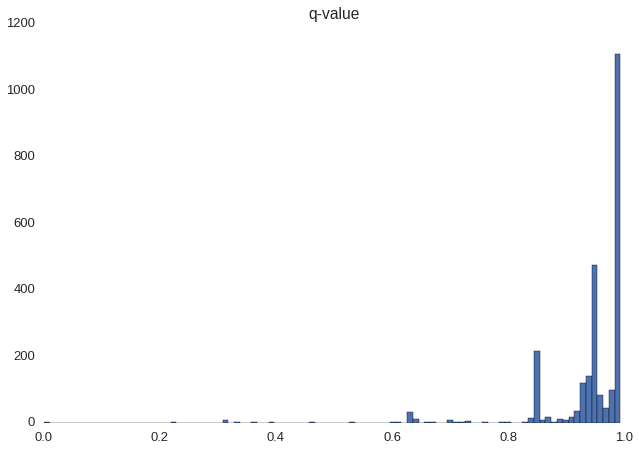

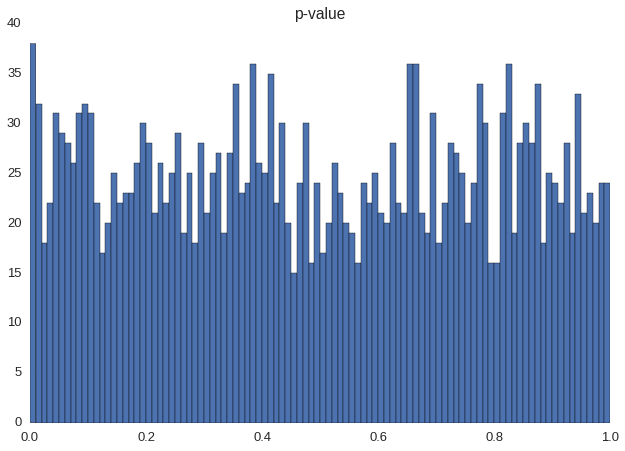

chose 141 candidates
squat/fructose_gwas_data_file.txt
squat/fructose_freqs_file.txt
squat/fructose_match_pop_file.txt
squat/fructose_full_dataset_file.txt
squat/AI_Q1_fructose_env_var_data_file.txt
squat/AI_Q2_fructose_env_var_data_file.txt
squat/AI_Q3_fructose_env_var_data_file.txt
squat/AI_Q4_fructose_env_var_data_file.txt


In [46]:
squat_outdir = "squat" #change for your username
if not os.path.exists(squat_outdir):
    os.mkdir(squat_outdir)

for p in alpha_vals:
    full = alpha_vals[p].T
    full['q-value'] = get_qvalues(full['p-value'])
    full.index = [x.replace(".", "-") for x in full.index]
    full.index = [x[1:] if x.startswith("X") else x for x in full.index]
    full.index.name = "SNP"
    full.AA = full.AA.apply(lambda x: x[0])
    full.aa = full.aa.apply(lambda x: x[0])
    full = full.rename(columns={'alpha':'EFF',
                                'AA':'A1',
                                'aa':'A2',
                                'p': 'FRQ'})
    candidates = full[full['p-value']<0.05]
    plt.hist(full['q-value'], bins=100)
    plt.title("q-value")
    plt.show()
    
    plt.hist(full['p-value'], bins=100)
    plt.title("p-value")
    plt.show()
    print "chose %d candidates" % len(candidates)
    write_gwas_data_file(candidates, p, squat_outdir)
    write_freqs_file(candidates, p, pop_allele_freqs, squat_outdir)
    write_match_pop_file(full, p, pop_allele_freqs, 2, squat_outdir)
    write_full_dataset_file(full, p, pop_allele_freqs, squat_outdir)
    write_env_var_data_file(p, pop_allele_freqs, squat_outdir)

####Examine the output above.

We've written several files.  

1. Can you decifer what each file is for?  Have a look at them with either `!head` or `!cat`. 

1. How many candidate genes are in your GWAS?

1. Why might there be 4 files for AI?

The following bits of code set up the input file for SQUAT.

In [48]:
env_squat_files = !find {squat_outdir} | grep {trait_name} | grep env_var | grep AI
print env_squat_files
env_squat_files = [os.path.basename(x) for x in env_squat_files]


['squat/AI_Q1_fructose_env_var_data_file.txt', 'squat/AI_Q2_fructose_env_var_data_file.txt', 'squat/AI_Q3_fructose_env_var_data_file.txt', 'squat/AI_Q4_fructose_env_var_data_file.txt']


In [49]:
env_var_file_string = "list(%s)" % ", ".join(["'%s'" % x for x in env_squat_files])

In [50]:
squat_scripts_dir = "/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts"
!rm {squat_outdir}/Scripts
!cd {squat_outdir} && ln -s {squat_scripts_dir} .
def get_squat_vars(pheno):
    d = {"gwas.data.file":"'%s_gwas_data_file.txt'" % pheno,
         "freqs.file":"'%s_freqs_file.txt'" % pheno,
         "env.var.data.files": env_var_file_string,
         "match.pop.file":"'%s_match_pop_file.txt'" % pheno,
         "full.dataset.file":"'%s_full_dataset_file.txt'" % pheno,
         "path":"'%s'" % pheno,
         "match.categories":"c('MAF')",
         "match.bins":"list(seq(0,0.5,0.02), c(2), seq(0,1000,100))",
         "cov.SNPs.per.cycle":5000,
         "cov.cycles":1,
         "null.phenos.per.cycle":1000,
         "null.cycles":1,
         "load.cov.mat":"F",
         "sim.null":"T",
         "check.allele.orientation":"F"}
    return ',\n'.join("%s=%s" % (key,val) for (key,val) in d.items())

def create_squat_run_file(pheno):
    squat_file = os.path.join(squat_outdir, "squat_%s.r" % pheno)
    with open(squat_file, "w") as o:
        o.write('system("rm -rf %s")\n'% pheno)
        o.write("source('%s')\n" % os.path.join(squat_scripts_dir, "CreateTraitFile.R"))
        o.write("source('%s')\n" % os.path.join(squat_scripts_dir, "functions.R"))
        o.write("PolygenicAdaptationFunction(%s)\n" % get_squat_vars(pheno))
    return squat_file

for pheno in alpha_vals:
    squat_file = create_squat_run_file(pheno)
    print squat_file
    !cat $squat_file
    print ""

squat/squat_fructose.r
system("rm -rf fructose")
source('/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts/CreateTraitFile.R')
source('/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts/functions.R')
PolygenicAdaptationFunction(sim.null=T,
cov.SNPs.per.cycle=5000,
null.cycles=1,
match.bins=list(seq(0,0.5,0.02), c(2), seq(0,1000,100)),
load.cov.mat=F,
path='fructose',
cov.cycles=1,
match.pop.file='fructose_match_pop_file.txt',
freqs.file='fructose_freqs_file.txt',
env.var.data.files=list('AI_Q1_fructose_env_var_data_file.txt', 'AI_Q2_fructose_env_var_data_file.txt', 'AI_Q3_fructose_env_var_data_file.txt', 'AI_Q4_fructose_env_var_data_file.txt'),
gwas.data.file='fructose_gwas_data_file.txt',
full.dataset.file='fructose_full_dataset_file.txt',
match.categories=c('MAF'),
check.allele.orientation=F,
null.phenos.per.cycle=1000)



####If all goes well, you should be able to run SQUAT.  If it fails, come and get me.

In [51]:
def run_squat(p):
    print "running %s" % p
    output = "%s/%s" % (squat_outdir, p)
    if os.path.exists(output):
        !rm -rf {output}
    cmds = ["setwd('%s')" % squat_outdir,
            'source("squat_%s.r")' % (p),
            "setwd('../')"]
    for cmd in cmds:
        print cmd
        r(cmd)
    
run_squat(trait_name)

running fructose
setwd('squat')
source("squat_fructose.r")
setwd('../')


####You can get the files that SQUAT wrote directly from the file system using `find` and `grep`

In [52]:
rfiles = !find {squat_outdir} | grep Robj | grep Output | grep {trait_name}
bc = {}
for f in rfiles:
    d = f.split("/")
    if not d[1] in bc:
        bc[d[1]] = []
    bc[d[1]].append(f)
bc

{'fructose': ['squat/fructose/Output/genetic.values.Robj',
  'squat/fructose/Output/theStats.Robj',
  'squat/fructose/Output/asymptotic.pVals.Robj',
  'squat/fructose/Output/pVals.Robj',
  'squat/fructose/Output/nullStats.Robj']}

####Let's examine the outputs

1. What is the $Qx$ value.  Is it significant?
1. Is anything interesting reported in the decomosition into $F_{ST}$ or LD?

In [53]:
for pheno in bc:
    print pheno
    for obj in bc[pheno]:
        r('load("%s")' % obj)
    print r("the.stats")
    print("------------------")
    print r("p.vals")

fructose
$Qx
[1] 34.39523

$Fst.comp
[1] 26.41663

$LD.component
[1] 7.978595

$betas
$betas[[1]]
[1] 0.002508158

$betas[[2]]
[1] 0.1020265

$betas[[3]]
[1] 0.08164254

$betas[[4]]
[1] -0.01178895


$pearson.rs
$pearson.rs[[1]]
[1] 0.06077921

$pearson.rs[[2]]
[1] 0.1619121

$pearson.rs[[3]]
[1] 0.2455743

$pearson.rs[[4]]
[1] -0.08066323


$spearman.rhos
$spearman.rhos[[1]]
          [,1]
[1,] 0.1965517

$spearman.rhos[[2]]
          [,1]
[1,] 0.2369458

$spearman.rhos[[3]]
          [,1]
[1,] 0.2137931

$spearman.rhos[[4]]
            [,1]
[1,] -0.01428571


$reg.Z
           Env File 1  Env File 2  Env File 3  Env File 4
Region 1  -1.78561095 -1.78561095 -1.78561095 -1.78561095
Region 2   0.01224845  0.01224845  0.01224845  0.01224845
Region 3  -1.29429148 -1.29429148 -1.29429148 -1.29429148
Region 4   0.44678898  0.44678898  0.44678898  0.44678898
Region 5  -1.00792002 -1.00792002 -1.00792002 -1.00792002
Region 6   0.41405447  0.41405447  0.41405447  0.41405447
Region 7  -1.165691

####We can now look at the influence of populations in driving environmental correlations

1. Are there populations which show elevated or depressed assocaition with environment?

In [54]:
the_stats = r['the.stats']
the_stats = com.convert_robj(the_stats.rx("ind.Z"))['ind.Z']

In [55]:
def convert_to_county(elem):
    for k, v in county_id.items():
        if int(v) == int(elem):
            return k

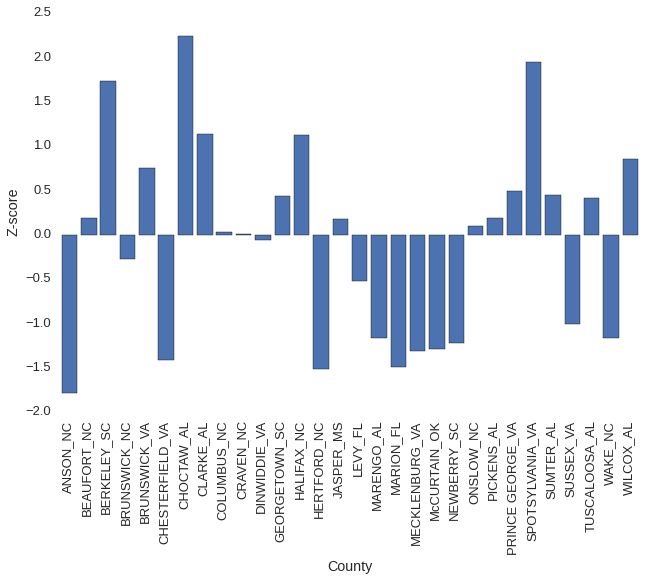

In [56]:
sns.barplot(the_stats.index, the_stats.values)
plt.ylabel("Z-score")
plt.xlabel("County")
ax = plt.gca()
ax.set_xticklabels(map(convert_to_county, the_stats.index), rotation=90)
plt.show()